In [3]:
# Jan. 12, 2021
# Use the depresjon dataset to forecast health monitor activity based on existing health monitor activity
# Split into depressed (condition) and nondepressed (control) groups, so that they are two separate models
# Could you then forecast a new data point and classify whether they're depressed/nondepressed based on how similar their actual next day is to the forecast result from each of the models?

# In a separate notebook, can also try out predicting whether someone is depressed based on their health monitor activity?

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
from datetime import datetime
import random
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from sklearn.metrics import mean_squared_error

In [4]:
os.getcwd()

'/Users/Claire/code/github.com/claire.y.yang/predicting-depression/nb'

In [5]:
condition_directory = "../data/condition"
control_directory = "../data/control/"

condition_dict = {}
control_dict = {}

for filename in os.listdir(condition_directory):
    if filename.endswith(".csv"): 
        condition_file_path = os.path.join(condition_directory, filename)
        df_condition = pd.read_csv(condition_file_path)
        subj = filename.split(".")[0]
        condition_dict[subj] = df_condition
        continue
    else:
        continue
        
for filename in os.listdir(control_directory):
    if filename.endswith(".csv"): 
        control_file_path = os.path.join(control_directory, filename)
        df_control = pd.read_csv(control_file_path)
        subj = filename.split(".")[0]
        control_dict[subj] = df_control
        continue
    else:
        continue
        

In [6]:
# First, create a column in each df denoting the Y, M, d, H, M
for cond in condition_dict:
    cond_df = condition_dict[cond]
    years = []
    months = []
    days = []
    hours = []
    minutes = []
    for idx, row in cond_df.iterrows():
        timestamp = row['timestamp']
        parsed_timestamp = datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S")
        years.append(parsed_timestamp.year)
        months.append(parsed_timestamp.month)
        days.append(parsed_timestamp.day)
        hours.append(parsed_timestamp.hour)
        minutes.append(parsed_timestamp.minute)
        
    cond_df['Year'] = years
    cond_df['Month'] = months
    cond_df['Day'] = days
    cond_df['Hour'] = hours
    cond_df['Minute'] = minutes


In [7]:
# Get rid of days in which we do not have the full 24 hours of data

new_condition_dict = {}
for cond in condition_dict:
    cond_df = condition_dict[cond]
    cur_ymd = (9999, 1, 1)
    days_to_be_removed = []
    
    for idx, row in cond_df.iterrows():
        ymd = (row['Year'], row['Month'], row['Day'])
        if cur_ymd != ymd:
            # Check if the hour and minute are equal to 0, 0
            if row['Hour'] != 0:
                # Then we remove all rows containing data of this day
                days_to_be_removed.append(ymd)
            cur_ymd = ymd
        
        # If it's the last row, and the hour and minute do not equal 23, 59, then remove the whole day
        if idx == len(cond_df) - 1:
            if row['Hour'] != 23 and row['Minute'] != 59:
                days_to_be_removed.append(ymd)
        
#     print("Beforehand Month, Day list:", set(cond_df['Month']), set(cond_df['Day']))
    # Now actually remove the day in cond_df
    for day in days_to_be_removed:
        cond_df = cond_df[cond_df['Day'] != day[2]]
        
    new_condition_dict[cond] = cond_df
        
#     print("Afterward Month, Day list:", set(cond_df['Month']), set(cond_df['Day']))

In [8]:
# Downsample so that it's for each half hour for each value
# Then, create a dictionary of vectors for each condition
# we will then use this to create the train, test sets

summed_condition_dict = {}

for cond in new_condition_dict:
    new_cond_df = new_condition_dict[cond]
    new_cond_df['timestamp'] = pd.to_datetime(new_cond_df['timestamp'], errors='coerce')
    summed_cond_dict = dict(new_cond_df.set_index('timestamp').resample("30T").sum()['activity'])
    
    list_vectors = []
    cur_day = 0
    cur_day_vector = []
    
    for time in summed_cond_dict:
        day = time.day
        activity_30_min = summed_cond_dict[time]
        if day != cur_day:
            if cur_day != 0:
                list_vectors.append(cur_day_vector)
            # It's a new day, so just reset + append to a new cur_day_vector
            cur_day_vector = [activity_30_min]
            cur_day = day
        else:
            cur_day_vector.append(activity_30_min)
            
    list_vectors.append(cur_day_vector) # append the last cur_day_vector
    
    summed_condition_dict[cond] = list_vectors
    
# list_vectors should be 48 x n dimensional

In [9]:
# Now, create a function that will split the dictionary into different vectors, with input look_back

def split_input(dictionary, look_back=2, num_timesteps = 2):
    X_y_list = []
    
    for subj in dictionary:
        list_vectors = dictionary[subj]
        for i in range(0, len(list_vectors) - (look_back + num_timesteps)):
            X = list_vectors[i:i + look_back]
            y = list_vectors[i + look_back: i + look_back + num_timesteps]
#             print("This is X:", len(X))
#             print("This is y:", len(y))
            X_y_list.append((X, y))
            
    return X_y_list
            
data_list = split_input(summed_condition_dict, look_back=2, num_timesteps=2)

In [10]:
# With lookback = 2, there are 267 samples with depression
print(len(data_list))
print(data_list[0][0])

267
[[511, 0, 550, 1775, 47, 533, 1058, 1750, 0, 0, 1025, 652, 307, 0, 2120, 923, 697, 1072, 1968, 47, 1297, 14183, 4349, 15759, 9740, 16737, 18016, 9750, 21782, 20840, 13360, 3298, 201, 187, 355, 207, 11126, 13095, 8169, 16105, 3760, 9106, 6851, 5307, 4536, 2671, 5433, 5691], [2560, 10563, 10861, 18351, 1639, 116, 57, 48, 90, 15, 908, 748, 2801, 3061, 115, 425, 1137, 156, 0, 255, 16637, 12762, 4490, 2764, 0, 96, 4287, 3417, 6243, 5933, 6685, 4768, 19013, 23376, 126, 3700, 14886, 9783, 9661, 3603, 5435, 1973, 7071, 15374, 4812, 2276, 5615, 8740]]


In [11]:
# Now, we should do a random split of the sample, so that it's 75% training, 25% testing

data = [i for i in range(0, len(data_list))]
random.shuffle(data)

train_split = int(len(data_list) * 0.75)

train_indices = data[:train_split]
testing_indices = data[train_split:]

train_X = []
train_y = []
test_X = []
test_y = []

for i in range(0, len(data_list)):
    if i in train_indices:
        train_X.append(data_list[i][0])
        train_y.append(data_list[i][1])
    elif i in testing_indices:
        test_X.append(data_list[i][0])
        test_y.append(data_list[i][1])

In [12]:
train_X = np.array(train_X)
train_y = np.array(train_y)

test_X = np.array(test_X)
test_y = np.array(test_y)

In [13]:
# let's normalize the training data

def normalize_data(orig_data):
    orig_data_shape = orig_data.shape
    reshaped_data = orig_data.reshape((orig_data_shape[0] * orig_data_shape[1], orig_data_shape[2]))
    norm_reshaped_data = preprocessing.normalize(reshaped_data, axis=1)
    norm_orig_data = norm_reshaped_data.reshape((orig_data_shape[0], orig_data_shape[1], orig_data_shape[2]))
    return norm_orig_data


norm_train_X = normalize_data(train_X)
norm_train_y = normalize_data(train_y)
norm_test_X = normalize_data(test_X)
norm_test_y = normalize_data(test_y)

# train_X_shape = train_X.shape
# reshaped_train_X = train_X.reshape((train_X_shape[0] * train_X_shape[1], train_X_shape[2]))
# norm_reshaped_train_X = preprocessing.normalize(reshaped_train_X, axis=1)
# norm_train_X = norm_reshaped_train_X.reshape((train_X_shape[0], train_X_shape[1], train_X_shape[2]))

# train_y_shape = train_y.shape
# reshaped_train_y = train_y.reshape((train_y_shape[0] * train_y_shape[1], train_y_shape[2]))
# norm_reshaped_train_y = preprocessing.normalize(reshaped_train_y, axis=1)
# norm_train_y = norm_reshaped_train_y.reshape((train_y_shape[0], train_y_shape[1], train_y_shape[2]))


In [14]:
sc_X = MinMaxScaler()
train_X_shape = train_X.shape
reshaped_train_X = train_X.reshape((train_X_shape[0] * train_X_shape[1], train_X_shape[2]))
transposed_train_X = np.transpose(reshaped_train_X)
scaled_transposed_train_X = sc_X.fit_transform(transposed_train_X)
scaled_reshaped_train_X = np.transpose(scaled_transposed_train_X)
scaled_train_X = scaled_reshaped_train_X.reshape((train_X_shape[0], train_X_shape[1], train_X_shape[2]))


sc_y = MinMaxScaler()
train_y_shape = train_y.shape
reshaped_train_y = train_y.reshape((train_y_shape[0] * train_y_shape[1], train_y_shape[2]))
transposed_train_y = np.transpose(reshaped_train_y)
scaled_transposed_train_y = sc_y.fit_transform(transposed_train_y)
scaled_reshaped_train_y = np.transpose(scaled_transposed_train_y)
scaled_train_y = scaled_reshaped_train_y.reshape((train_y_shape[0], train_y_shape[1], train_y_shape[2]))


In [15]:
# Use Keras
# I referenced this: https://stackabuse.com/solving-sequence-problems-with-lstm-in-keras-part-2/
# This is a many-to-many sequence problem with multiple features
model = Sequential()
# encoder layer
model.add(LSTM(16, activation='relu', input_shape=(2, 48)))
# repeat vector
model.add(RepeatVector(2)) # we are repeating by outputting two timesteps in the future
# decoder layer
model.add(LSTM(16, activation='relu', return_sequences=True))

model.add(TimeDistributed(Dense(48)))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16)                4160      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 2, 16)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 2, 16)             2112      
_________________________________________________________________
time_distributed (TimeDistri (None, 2, 48)             816       
Total params: 7,088
Trainable params: 7,088
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
history = model.fit(scaled_train_X, scaled_train_y, epochs=250, validation_split=0.2, verbose=1, batch_size=3)

Epoch 1/250
54/54 [==============================] - 3s 16ms/step - loss: 0.1117 - accuracy: 0.0511 - val_loss: 0.0817 - val_accuracy: 0.0500
Epoch 2/250
54/54 [==============================] - 0s 7ms/step - loss: 0.0771 - accuracy: 0.0350 - val_loss: 0.0605 - val_accuracy: 0.0375
Epoch 3/250
54/54 [==============================] - 0s 5ms/step - loss: 0.0591 - accuracy: 0.0595 - val_loss: 0.0572 - val_accuracy: 0.0500
Epoch 4/250
54/54 [==============================] - 0s 5ms/step - loss: 0.0602 - accuracy: 0.0548 - val_loss: 0.0561 - val_accuracy: 0.0250
Epoch 5/250
54/54 [==============================] - 0s 5ms/step - loss: 0.0610 - accuracy: 0.0427 - val_loss: 0.0554 - val_accuracy: 0.0500
Epoch 6/250
54/54 [==============================] - 0s 5ms/step - loss: 0.0564 - accuracy: 0.0418 - val_loss: 0.0542 - val_accuracy: 0.0250
Epoch 7/250
54/54 [==============================] - 0s 5ms/step - loss: 0.0552 - accuracy: 0.0649 - val_loss: 0.0554 - val_accuracy: 0.0375
Epoch 8/250


54/54 [==============================] - 0s 4ms/step - loss: 0.0401 - accuracy: 0.0793 - val_loss: 0.0587 - val_accuracy: 0.0000e+00
Epoch 59/250
54/54 [==============================] - 0s 4ms/step - loss: 0.0399 - accuracy: 0.1035 - val_loss: 0.0588 - val_accuracy: 0.0000e+00
Epoch 60/250
54/54 [==============================] - 0s 5ms/step - loss: 0.0406 - accuracy: 0.0810 - val_loss: 0.0582 - val_accuracy: 0.0000e+00
Epoch 61/250
54/54 [==============================] - 0s 4ms/step - loss: 0.0394 - accuracy: 0.1194 - val_loss: 0.0584 - val_accuracy: 0.0125
Epoch 62/250
54/54 [==============================] - 0s 4ms/step - loss: 0.0410 - accuracy: 0.0669 - val_loss: 0.0591 - val_accuracy: 0.0125
Epoch 63/250
54/54 [==============================] - 0s 4ms/step - loss: 0.0428 - accuracy: 0.0783 - val_loss: 0.0586 - val_accuracy: 0.0125
Epoch 64/250
54/54 [==============================] - 0s 4ms/step - loss: 0.0408 - accuracy: 0.0909 - val_loss: 0.0595 - val_accuracy: 0.0000e+00
Epo

54/54 [==============================] - 0s 5ms/step - loss: 0.0360 - accuracy: 0.1645 - val_loss: 0.0652 - val_accuracy: 0.0000e+00
Epoch 116/250
54/54 [==============================] - 0s 4ms/step - loss: 0.0366 - accuracy: 0.0996 - val_loss: 0.0644 - val_accuracy: 0.0125
Epoch 117/250
54/54 [==============================] - 0s 5ms/step - loss: 0.0373 - accuracy: 0.0754 - val_loss: 0.0656 - val_accuracy: 0.0125
Epoch 118/250
54/54 [==============================] - 0s 4ms/step - loss: 0.0379 - accuracy: 0.1192 - val_loss: 0.0651 - val_accuracy: 0.0125
Epoch 119/250
54/54 [==============================] - 0s 5ms/step - loss: 0.0364 - accuracy: 0.1222 - val_loss: 0.0648 - val_accuracy: 0.0250
Epoch 120/250
54/54 [==============================] - 0s 4ms/step - loss: 0.0368 - accuracy: 0.1348 - val_loss: 0.0659 - val_accuracy: 0.0250
Epoch 121/250
54/54 [==============================] - 0s 4ms/step - loss: 0.0383 - accuracy: 0.1116 - val_loss: 0.0650 - val_accuracy: 0.0125
Epoch 122

Epoch 172/250
54/54 [==============================] - 0s 4ms/step - loss: 0.0334 - accuracy: 0.1176 - val_loss: 0.0683 - val_accuracy: 0.0125
Epoch 173/250
54/54 [==============================] - 0s 4ms/step - loss: 0.0357 - accuracy: 0.1378 - val_loss: 0.0689 - val_accuracy: 0.0125
Epoch 174/250
54/54 [==============================] - 0s 4ms/step - loss: 0.0342 - accuracy: 0.1698 - val_loss: 0.0682 - val_accuracy: 0.0250
Epoch 175/250
54/54 [==============================] - 0s 5ms/step - loss: 0.0330 - accuracy: 0.1910 - val_loss: 0.0685 - val_accuracy: 0.0250
Epoch 176/250
54/54 [==============================] - 0s 5ms/step - loss: 0.0335 - accuracy: 0.1850 - val_loss: 0.0692 - val_accuracy: 0.0125
Epoch 177/250
54/54 [==============================] - 0s 4ms/step - loss: 0.0339 - accuracy: 0.1991 - val_loss: 0.0685 - val_accuracy: 0.0125
Epoch 178/250
54/54 [==============================] - 0s 5ms/step - loss: 0.0352 - accuracy: 0.1494 - val_loss: 0.0688 - val_accuracy: 0.0250

54/54 [==============================] - 0s 4ms/step - loss: 0.0322 - accuracy: 0.1675 - val_loss: 0.0721 - val_accuracy: 0.0000e+00
Epoch 230/250
54/54 [==============================] - 0s 4ms/step - loss: 0.0330 - accuracy: 0.1926 - val_loss: 0.0750 - val_accuracy: 0.0375
Epoch 231/250
54/54 [==============================] - 0s 4ms/step - loss: 0.0324 - accuracy: 0.2119 - val_loss: 0.0727 - val_accuracy: 0.0250
Epoch 232/250
54/54 [==============================] - 0s 4ms/step - loss: 0.0319 - accuracy: 0.1656 - val_loss: 0.0728 - val_accuracy: 0.0250
Epoch 233/250
54/54 [==============================] - 0s 4ms/step - loss: 0.0333 - accuracy: 0.2008 - val_loss: 0.0723 - val_accuracy: 0.0250
Epoch 234/250
54/54 [==============================] - 0s 4ms/step - loss: 0.0321 - accuracy: 0.1874 - val_loss: 0.0733 - val_accuracy: 0.0000e+00
Epoch 235/250
54/54 [==============================] - 0s 5ms/step - loss: 0.0321 - accuracy: 0.1831 - val_loss: 0.0743 - val_accuracy: 0.0250
Epoch

Text(0.5, 1.0, 'Loss of Simple LSTM trained over 250 epochs on two timesteps to predict the two future timesteps')

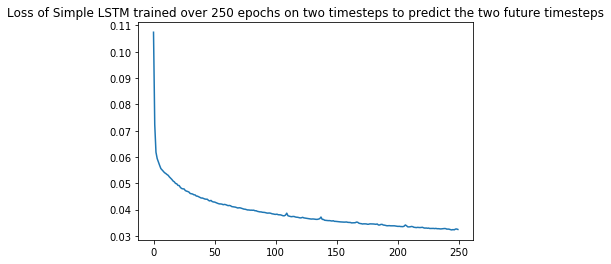

In [17]:
plt.plot(history.history['loss'])
plt.title("Loss of Simple LSTM trained over 250 epochs on two timesteps to predict the two future timesteps")

In [21]:
# TODO: also try out the test set
prediction = model.predict(scaled_train_X) # scaled inputs here

prediction_shape = prediction.shape
reshaped_scaled_prediction = prediction.reshape((prediction_shape[0] * prediction_shape[1], prediction_shape[2]))
transposed_scaled_prediction = np.transpose(reshaped_scaled_prediction)
transposed_prediction = sc_y.inverse_transform(transposed_scaled_prediction)
reshaped_prediction = np.transpose(transposed_prediction)
unscaled_prediction = reshaped_prediction.reshape((prediction_shape[0], prediction_shape[1], prediction_shape[2]))

for j in range(0, len(train_y)):
    MSE = mean_squared_error(train_y[j], unscaled_prediction[j])  # first 2 steps, combined
    print(np.sqrt(MSE))

3698.0527403013366
4976.136907855071
5370.2644497918745
6292.0742251657775
6037.821884532669
5791.449188137154
7229.5144772564445
7144.647085414111
4407.848582668335
5244.607727280552
4338.594223731138
89.87989041208681
65.28427533280569
2786.7100604828674
3141.572446143844
4076.953245632292
3607.1459946931973
3019.342560895238
3263.123067359981
3642.7901252795373
3545.678550069501
2091.5167855644963
1723.1977334676478
1773.494682705966
2751.4275216141714
2977.010382392761
3038.465380737192
1741.894500055133
1916.5135719386524
1762.331548233638
0.04096485998756802
2378.761556523217
3344.22569668888
2537.0559341141557
3302.0366710869175
3198.4206645466784
3096.946418274059
2261.636047731988
3743.158963306135
3882.2693429816027
3421.1288260409415
4401.220526663285
3788.9536958815443
3373.448149632302
3769.5404434400175
1251.0005067520456
1677.3688146805491
1581.3708009876202
2137.4613692331304
2138.0130747108715
1909.296206171019
5061.3586198803305
7596.605765538812
5651.836435159657
591

In [22]:
unscaled_prediction

array([[[ 5320.862  ,  3888.5942 ,  2225.3535 , ...,  8806.221  ,
          8274.571  ,  5315.4727 ],
        [ 3496.989  ,   960.16174,  -322.05447, ...,  7549.106  ,
          6449.2095 ,  4176.372  ]],

       [[ 6053.2896 ,  3841.9524 ,  2316.5483 , ...,  9547.418  ,
          8326.01   ,  6123.5625 ],
        [ 6203.8486 ,  3870.1052 ,  2714.313  , ...,  9427.046  ,
          7992.4414 ,  6182.949  ]],

       [[ 6100.64   ,  4606.6313 ,  3268.6968 , ..., 10057.348  ,
          8678.555  ,  7175.0923 ],
        [ 3039.6545 ,  1169.715  ,   177.17844, ...,  7045.6626 ,
          5329.054  ,  5451.834  ]],

       ...,

       [[ 4231.7886 ,  3777.97   ,  3380.6484 , ...,  4212.6895 ,
          4687.113  ,  3160.9304 ],
        [ 2754.8433 ,  2854.9268 ,  2868.3232 , ...,  2330.8796 ,
          3009.496  ,  2383.4526 ]],

       [[ 4302.7383 ,  4411.856  ,  2744.4446 , ...,  5386.858  ,
          5172.237  ,  4173.622  ],
        [ 2737.6519 ,  2990.7385 ,  1542.5688 , ...,  4034.76

In [23]:
train_y

array([[[ 6677,  2402,   151, ...,  4718,  4867,  4640],
        [ 9221,   709,    59, ...,  6860,  5879,   918]],

       [[ 2055,   494,   288, ..., 14954,  1117,  2515],
        [ 1576,   293,    85, ..., 12784, 19084,  2854]],

       [[ 1576,   293,    85, ..., 12784, 19084,  2854],
        [  208,  1686,   660, ...,  5381, 16714, 13304]],

       ...,

       [[  212,   301,   341, ...,  9424,  9047, 10839],
        [ 2133,  1465,   307, ...,  3137,  2649,  2341]],

       [[ 2133,  1465,   307, ...,  3137,  2649,  2341],
        [ 2557,  1088,  2731, ...,  3519,  5803,   911]],

       [[ 2557,  1088,  2731, ...,  3519,  5803,   911],
        [ 2073,   981,  1454, ...,     0,     0,     0]]])

In [24]:
# Now try a bidirectional LSTM
bidir_model = Sequential()
bidir_model.add(Bidirectional(LSTM(16, activation='relu', input_shape=(2, 48))))
bidir_model.add(RepeatVector(2))
bidir_model.add(Bidirectional(LSTM(16, activation='relu', return_sequences=True)))
bidir_model.add(TimeDistributed(Dense(48)))

bidir_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# print(bidir_model.summary())

In [25]:
bidir_history = bidir_model.fit(scaled_train_X, scaled_train_y, epochs=250, validation_split=0.2, verbose=1, batch_size=3)

Epoch 1/250
54/54 [==============================] - 6s 17ms/step - loss: 0.1103 - accuracy: 0.0157 - val_loss: 0.0658 - val_accuracy: 0.0375
Epoch 2/250
54/54 [==============================] - 0s 8ms/step - loss: 0.0685 - accuracy: 0.0366 - val_loss: 0.0553 - val_accuracy: 0.0125
Epoch 3/250
54/54 [==============================] - 0s 6ms/step - loss: 0.0606 - accuracy: 0.0554 - val_loss: 0.0546 - val_accuracy: 0.0125
Epoch 4/250
54/54 [==============================] - 0s 6ms/step - loss: 0.0565 - accuracy: 0.0764 - val_loss: 0.0537 - val_accuracy: 0.0000e+00
Epoch 5/250
54/54 [==============================] - 0s 6ms/step - loss: 0.0576 - accuracy: 0.0667 - val_loss: 0.0535 - val_accuracy: 0.0000e+00
Epoch 6/250
54/54 [==============================] - 0s 6ms/step - loss: 0.0541 - accuracy: 0.0901 - val_loss: 0.0533 - val_accuracy: 0.0000e+00
Epoch 7/250
54/54 [==============================] - 0s 6ms/step - loss: 0.0520 - accuracy: 0.0890 - val_loss: 0.0527 - val_accuracy: 0.0000e

54/54 [==============================] - 0s 6ms/step - loss: 0.0348 - accuracy: 0.1497 - val_loss: 0.0623 - val_accuracy: 0.0000e+00
Epoch 59/250
54/54 [==============================] - 0s 6ms/step - loss: 0.0339 - accuracy: 0.1716 - val_loss: 0.0613 - val_accuracy: 0.0000e+00
Epoch 60/250
54/54 [==============================] - 0s 6ms/step - loss: 0.0351 - accuracy: 0.1901 - val_loss: 0.0618 - val_accuracy: 0.0125
Epoch 61/250
54/54 [==============================] - 0s 6ms/step - loss: 0.0341 - accuracy: 0.1741 - val_loss: 0.0625 - val_accuracy: 0.0125
Epoch 62/250
54/54 [==============================] - 0s 7ms/step - loss: 0.0338 - accuracy: 0.2041 - val_loss: 0.0625 - val_accuracy: 0.0125
Epoch 63/250
54/54 [==============================] - 0s 7ms/step - loss: 0.0341 - accuracy: 0.2277 - val_loss: 0.0627 - val_accuracy: 0.0000e+00
Epoch 64/250
54/54 [==============================] - 0s 6ms/step - loss: 0.0317 - accuracy: 0.1646 - val_loss: 0.0634 - val_accuracy: 0.0000e+00
Epo

54/54 [==============================] - 0s 5ms/step - loss: 0.0263 - accuracy: 0.3182 - val_loss: 0.0737 - val_accuracy: 0.0250
Epoch 116/250
54/54 [==============================] - 0s 5ms/step - loss: 0.0256 - accuracy: 0.2645 - val_loss: 0.0737 - val_accuracy: 0.0250
Epoch 117/250
54/54 [==============================] - 0s 5ms/step - loss: 0.0264 - accuracy: 0.2817 - val_loss: 0.0745 - val_accuracy: 0.0250
Epoch 118/250
54/54 [==============================] - 0s 5ms/step - loss: 0.0268 - accuracy: 0.2868 - val_loss: 0.0740 - val_accuracy: 0.0375
Epoch 119/250
54/54 [==============================] - 0s 5ms/step - loss: 0.0271 - accuracy: 0.2631 - val_loss: 0.0755 - val_accuracy: 0.0250
Epoch 120/250
54/54 [==============================] - 0s 5ms/step - loss: 0.0266 - accuracy: 0.2407 - val_loss: 0.0751 - val_accuracy: 0.0375
Epoch 121/250
54/54 [==============================] - 0s 5ms/step - loss: 0.0261 - accuracy: 0.2829 - val_loss: 0.0741 - val_accuracy: 0.0375
Epoch 122/250

54/54 [==============================] - 0s 5ms/step - loss: 0.0234 - accuracy: 0.3429 - val_loss: 0.0807 - val_accuracy: 0.0375
Epoch 173/250
54/54 [==============================] - 0s 5ms/step - loss: 0.0236 - accuracy: 0.3098 - val_loss: 0.0796 - val_accuracy: 0.0625
Epoch 174/250
54/54 [==============================] - 0s 5ms/step - loss: 0.0238 - accuracy: 0.3525 - val_loss: 0.0795 - val_accuracy: 0.0375
Epoch 175/250
54/54 [==============================] - 0s 5ms/step - loss: 0.0226 - accuracy: 0.3396 - val_loss: 0.0814 - val_accuracy: 0.0375
Epoch 176/250
54/54 [==============================] - 0s 5ms/step - loss: 0.0235 - accuracy: 0.3547 - val_loss: 0.0801 - val_accuracy: 0.0500
Epoch 177/250
54/54 [==============================] - 0s 5ms/step - loss: 0.0230 - accuracy: 0.3193 - val_loss: 0.0806 - val_accuracy: 0.0375
Epoch 178/250
54/54 [==============================] - 0s 5ms/step - loss: 0.0239 - accuracy: 0.2934 - val_loss: 0.0786 - val_accuracy: 0.0750
Epoch 179/250

54/54 [==============================] - 0s 5ms/step - loss: 0.0215 - accuracy: 0.3597 - val_loss: 0.0840 - val_accuracy: 0.0625
Epoch 230/250
54/54 [==============================] - 0s 5ms/step - loss: 0.0213 - accuracy: 0.4186 - val_loss: 0.0854 - val_accuracy: 0.0500
Epoch 231/250
54/54 [==============================] - 0s 5ms/step - loss: 0.0211 - accuracy: 0.3434 - val_loss: 0.0840 - val_accuracy: 0.0500
Epoch 232/250
54/54 [==============================] - 0s 5ms/step - loss: 0.0202 - accuracy: 0.4121 - val_loss: 0.0866 - val_accuracy: 0.0625
Epoch 233/250
54/54 [==============================] - 0s 5ms/step - loss: 0.0207 - accuracy: 0.3864 - val_loss: 0.0847 - val_accuracy: 0.0625
Epoch 234/250
54/54 [==============================] - 0s 5ms/step - loss: 0.0207 - accuracy: 0.3428 - val_loss: 0.0845 - val_accuracy: 0.0500
Epoch 235/250
54/54 [==============================] - 0s 6ms/step - loss: 0.0197 - accuracy: 0.4267 - val_loss: 0.0850 - val_accuracy: 0.0625
Epoch 236/250

Text(0.5, 1.0, 'Loss of Bidirectional LSTM trained over 250 epochs on two timesteps to predict the two future timesteps')

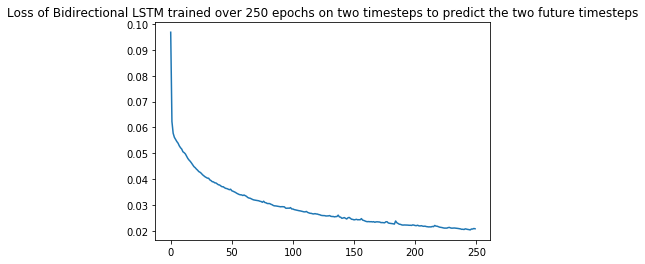

In [26]:
plt.plot(bidir_history.history['loss'])
plt.title("Loss of Bidirectional LSTM trained over 250 epochs on two timesteps to predict the two future timesteps")

Text(0.5, 1.0, 'Accuracy of Bidirectional LSTM trained over 250 epochs on two timesteps to predict the two future timesteps')

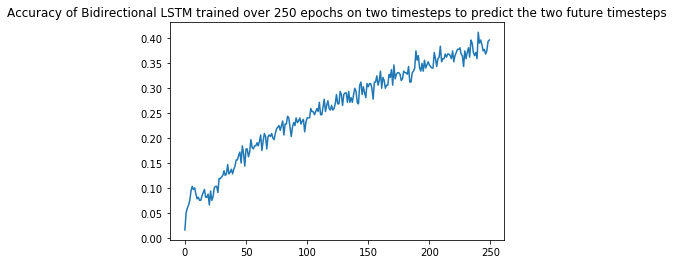

In [27]:
plt.plot(bidir_history.history['accuracy'])
plt.title("Accuracy of Bidirectional LSTM trained over 250 epochs on two timesteps to predict the two future timesteps")

In [28]:
# TODO: also try out the test set
prediction = bidir_model.predict(scaled_train_X) # scaled inputs here

prediction_shape = prediction.shape
reshaped_scaled_prediction = prediction.reshape((prediction_shape[0] * prediction_shape[1], prediction_shape[2]))
transposed_scaled_prediction = np.transpose(reshaped_scaled_prediction)
transposed_prediction = sc_y.inverse_transform(transposed_scaled_prediction)
reshaped_prediction = np.transpose(transposed_prediction)
unscaled_prediction = reshaped_prediction.reshape((prediction_shape[0], prediction_shape[1], prediction_shape[2]))

for j in range(0, len(train_y)):
    MSE = mean_squared_error(train_y[j], unscaled_prediction[j])  # first 2 steps, combined
    print(np.sqrt(MSE))

3417.0601864162063
4314.141736037075
4105.195186853962
4470.728041408934
5140.872192227804
4869.255133155195
5502.081766695044
6296.3262824107505
2756.4152510849835
4200.686225601163
3089.36167588058
72.0471260937174
61.894158087933015
2743.087690837875
2866.3448002372215
3651.1954651126052
2834.2049559666184
2485.834142020621
2393.2794082782852
2735.6460886732543
2667.3302358576334
1322.8032584872208
972.3211485663549
1176.865138621026
2467.2306969200895
2794.692799980827
2389.0891819866433
1319.3886759753022
1424.5976989327387
1204.300090481384
0.041578662786807434
2152.666612239587
2654.5181368133112
2364.4526805802434
2337.6514285364824
2652.2549400866837
2172.7242169849424
1758.9368599790675
2877.0150563628804
3100.717210814844
2919.358301448537
3326.9203275937793
2985.0538474630907
2850.8163397078906
2967.962895141865
928.5139342009182
1328.0411743942618
1077.1039243287776
1640.3582006682518
1802.6189933777341
1405.660238756234
3634.919318133716
3866.7376039767555
4197.0298678907

In [31]:
unscaled_prediction[1]

array([[ 5673.716  ,  3760.4326 ,  1632.8285 ,   957.1454 ,   464.97955,
           81.63861,   376.28052,   639.92316,   987.4446 ,  1048.6007 ,
          670.866  ,   462.58337,  1230.2246 ,   959.43317,  2014.1448 ,
         3685.3909 ,  4031.909  ,  1798.3014 ,   -70.93206,   500.90277,
         3622.045  ,  7603.781  ,  9134.165  ,  5718.9365 ,  8726.651  ,
         7797.184  ,  8974.328  ,  9154.961  , 10872.38   , 11772.932  ,
        14722.8955 , 11473.334  , 15105.835  , 16491.264  , 15356.397  ,
        19664.44   , 16750.111  ,  9596.258  ,  8446.713  , 10034.745  ,
         9797.659  , 14586.261  , 16539.613  , 14247.703  , 14378.989  ,
        13494.728  ,  9406.961  ,  7263.0835 ],
       [ 5010.65   ,  2887.1084 ,   867.87756,  -225.53505,  -552.41284,
        -1173.431  ,   278.99905,  -530.22784,   440.93863,  1407.9174 ,
          916.24677,   748.3553 ,    26.04026,  1928.9849 ,  1769.429  ,
         2044.4114 ,  1166.564  ,  1633.7379 ,   977.3203 , -1229.0613 ,
   

In [32]:
train_y[1]

array([[ 2055,   494,   288,   239,   887,   328,   181,   409,  1765,
            0,     0,   288,  1026,   392,     0,   293,   405,   505,
          178,  7179,  3457, 10847,  6963,  8525, 13048,  1358,  3330,
         3279, 13372, 12334,  7867,  3901, 19208, 29409, 13785, 18570,
        10736,  8403,  9040,  7323, 11006, 27118, 19324,  7149, 19454,
        14954,  1117,  2515],
       [ 1576,   293,    85,   238,   384,   411,   350,   372,   184,
         1567,   112,     0,   321,  1334,   218,     5,  1115,   668,
          524,     3,   359,   949,   450,   177, 10864, 12532, 23577,
        18537, 10041, 13588, 17043, 17374,  7333, 21375, 12092, 28552,
        15001, 19043, 10587, 11591, 12243, 12348, 10247, 27195,  9539,
        12784, 19084,  2854]])

In [ ]:
# Now try to predict the test set and compare?
test_pred_y = bidir_model.predict(norm_test_X, verbose=0)
print(test_pred_y)

In [ ]:
norm_test_y